# Healthcare Chatbot - Medical QA System

## Problem Statement

Access to accurate medical information is a global challenge. Patients struggle to find reliable health answers, leading to delayed care, misinformation from unreliable sources, and overwhelmed healthcare systems. This project addresses this gap by developing an AI-powered chatbot that provides evidence-based answers to medical questions.

## Domain Justification

Healthcare is chosen because:
- Universal relevance: health affects everyone
- Critical information gap between medical experts and public understanding
- Accessibility needs: not everyone has immediate access to healthcare professionals

The chatbot serves as an accessible first point of contact for health information, helping users understand medical conditions, learn about treatments, and make informed decisions about seeking professional care.

## Important Disclaimer

This chatbot provides general health information only and is NOT a substitute for professional medical advice. Users must consult qualified healthcare professionals for medical concerns.

## Experimental Approach

### Dataset: MedQuAD
- 16,407 expert-curated medical Q&A pairs from authoritative sources (NIH, CDC, FDA)
- Covers diseases, symptoms, treatments, and prevention
- Training: 13,087 | Validation: 1,636 | Test: 1,636 samples

### Model: Flan-T5-Small
- Google's instruction-tuned T5 model (80M parameters)
- Pre-trained for question-answering tasks
- Superior to base T5 for medical Q&A due to instruction-following capabilities

### Baseline to Beat
- BLEU: 0.0283
- ROUGE-L: 0.2102
- Target: >10% improvement through prompting and decoding strategies

### Framework
TensorFlow 2.19 with Hugging Face Transformers

## 1. Environment Setup

Installing required libraries for model training, evaluation, and data processing. The tf-keras package is installed first to ensure Keras 3 compatibility with TensorFlow.

In [1]:
%pip install -q tf-keras transformers tensorflow pandas numpy scikit-learn datasets evaluate rouge-score sacrebleu matplotlib seaborn
print("✓ Installed!")


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.2 MB/s eta 0:00:00
✓ Installed!


In [14]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, json
from pathlib import Path
import warnings
import re
import seaborn as sns
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
from datasets import Dataset
import evaluate, tensorflow as tf, tf_keras
from datetime import datetime

# Sklearn
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")


TensorFlow version: 2.19.0
GPU Available: True


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Data Loading and Exploration

The MedQuAD dataset contains expert-curated medical question-answer pairs from reliable sources. This section downloads the dataset from Kaggle and performs initial exploration to understand the data characteristics.

In [7]:
# Download dataset using Kaggle Hub API
import kagglehub
import shutil

print("Downloading MedQuAD dataset from Kaggle...")
print("This may take a few minutes on first run...")

# Download latest version
dataset_path = kagglehub.dataset_download("pythonafroz/medquad-medical-question-answer-for-ai-research")

print(f"\n✓ Dataset downloaded to: {dataset_path}")

# Copy to data directory
import os
from pathlib import Path

data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

# Find the CSV file in the downloaded path
csv_files = list(Path(dataset_path).glob('*.csv'))
if csv_files:
    source_file = csv_files[0]
    dest_file = data_dir / 'medquad.csv'
    shutil.copy(source_file, dest_file)
    print(f"✓ Dataset copied to: {dest_file}")
else:
    print("⚠️ No CSV file found. Please check the dataset structure.")
    print(f"Files in dataset: {list(Path(dataset_path).glob('*'))}")


This may take a few minutes on first run...


100%|██████████| 4.95M/4.95M [00:00<00:00, 79.8MB/s]

Extracting files...

✓ Dataset downloaded to: /root/.cache/kagglehub/datasets/pythonafroz/medquad-medical-question-answer-for-ai-research/versions/1
✓ Dataset copied to: data/medquad.csv


In [8]:
# Load the MedQuAD dataset
data_path = 'data/medquad.csv'
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nDataset Info:")
df.info()
print(f"\nFirst few rows:")
df.head()


Dataset shape: (16412, 4)

Column names: ['question', 'answer', 'source', 'focus_area']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16412 entries, 0 to 16411
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   question    16412 non-null  object
 1   answer      16407 non-null  object
 2   source      16412 non-null  object
 3   focus_area  16398 non-null  object
dtypes: object(4)
memory usage: 513.0+ KB

First few rows:


,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma


In [9]:
# Display sample Q&A pairs
print("Sample Medical Q&A Pairs:\n")
print("="*100)
for idx in range(min(3, len(df))):
    print(f"\nExample {idx+1}:")
    print(f"Question: {df.iloc[idx]['question']}")
    print(f"Answer: {df.iloc[idx]['answer'][:300]}...")
    if 'source' in df.columns:
        print(f"Source: {df.iloc[idx]['source']}")
    if 'focus_area' in df.columns:
        print(f"Focus Area: {df.iloc[idx]['focus_area']}")
    print("-"*100)


Sample Medical Q&A Pairs:


Example 1:
Question: What is (are) Glaucoma ?
Answer: Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. While glaucoma can strike anyone, the risk is much greater for people over 60. How Glaucoma Develops  There are several different types of glaucoma. Most of these involve the drainage syste...
Source: NIHSeniorHealth
Focus Area: Glaucoma
----------------------------------------------------------------------------------------------------

Example 2:
Question: What causes Glaucoma ?
Answer: Nearly 2.7 million people have glaucoma, a leading cause of blindness in the United States. Although anyone can get glaucoma, some people are at higher risk. They include - African-Americans over age 40  - everyone over age 60, especially Hispanics/Latinos  - people with a family history of glaucoma...
Source: NIHSeniorHealth
Focus Area: Glaucoma
------------------------------------------------------------------

In [10]:
# Basic statistics
print("Missing Values:")
print(df.isnull().sum())
print("\n" + "="*50)

# Text length analysis
df['question_length'] = df['question'].astype(str).apply(len)
df['answer_length'] = df['answer'].astype(str).apply(len)
df['question_words'] = df['question'].astype(str).apply(lambda x: len(x.split()))
df['answer_words'] = df['answer'].astype(str).apply(lambda x: len(x.split()))

print("\nText Length Statistics:")
print(df[['question_length', 'answer_length', 'question_words', 'answer_words']].describe())


Missing Values:
question       0
answer         5
source         0
focus_area    14
dtype: int64


Text Length Statistics:
       question_length  answer_length  question_words  answer_words
count     16412.000000   16412.000000    16412.000000  16412.000000
mean         50.684438    1303.056483        8.211918    201.293322
std          16.925355    1656.597408        2.381260    248.466938
min          16.000000       3.000000        3.000000      1.000000
25%          38.000000     487.000000        6.000000     71.000000
50%          48.000000     889.500000        8.000000    138.000000
75%          61.000000    1589.000000       10.000000    252.000000
max         191.000000   29046.000000       27.000000   4281.000000


## 3. Data Visualization

Visualizing the dataset helps identify patterns and potential issues. We examine:
- Question and answer length distributions to set appropriate token limits
- Medical focus areas to understand topic diversity
- Data sources to assess information reliability
- Question-answer relationships to understand complexity

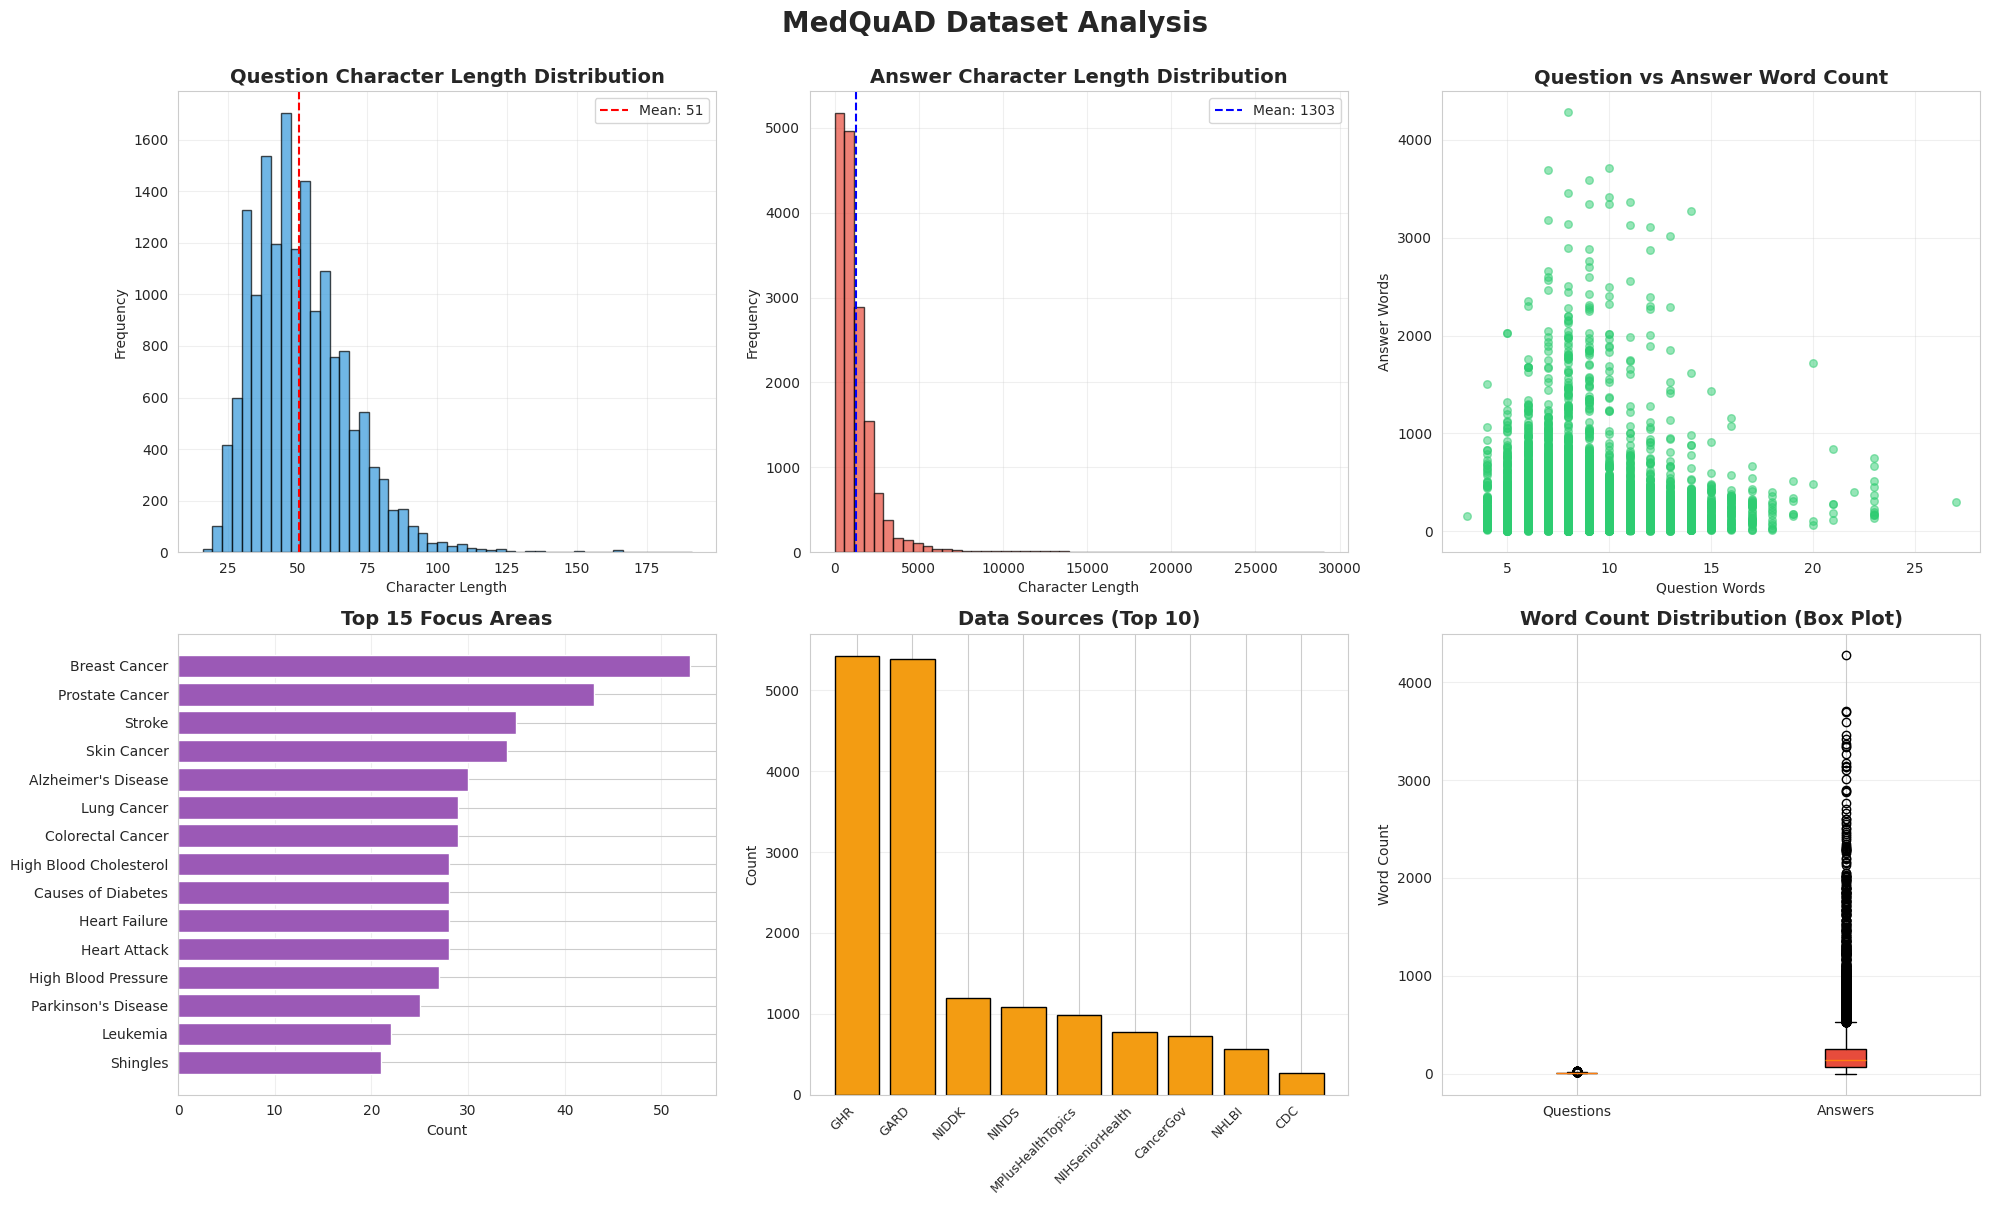

Visualization saved as 'dataset_analysis.png'


In [11]:
# Create 6 visualizations in 2 rows of 3
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('MedQuAD Dataset Analysis', fontsize=20, fontweight='bold', y=1.00)

# 1. Question Character Length Distribution
axes[0, 0].hist(df['question_length'], bins=50, edgecolor='black', alpha=0.7, color='#3498db')
axes[0, 0].set_title('Question Character Length Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Character Length')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['question_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["question_length"].mean():.0f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Answer Character Length Distribution
axes[0, 1].hist(df['answer_length'], bins=50, edgecolor='black', alpha=0.7, color='#e74c3c')
axes[0, 1].set_title('Answer Character Length Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Character Length')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df['answer_length'].mean(), color='blue', linestyle='--', label=f'Mean: {df["answer_length"].mean():.0f}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Question vs Answer Word Count
axes[0, 2].scatter(df['question_words'], df['answer_words'], alpha=0.5, c='#2ecc71', s=30)
axes[0, 2].set_title('Question vs Answer Word Count', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Question Words')
axes[0, 2].set_ylabel('Answer Words')
axes[0, 2].grid(True, alpha=0.3)

# 4. Focus Area Distribution (Top 15)
if 'focus_area' in df.columns:
    focus_counts = df['focus_area'].value_counts().head(15)
    axes[1, 0].barh(range(len(focus_counts)), focus_counts.values, color='#9b59b6')
    axes[1, 0].set_yticks(range(len(focus_counts)))
    axes[1, 0].set_yticklabels(focus_counts.index, fontsize=10)
    axes[1, 0].set_title('Top 15 Focus Areas', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Count')
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(True, alpha=0.3, axis='x')
else:
    axes[1, 0].text(0.5, 0.5, 'No Focus Area Data', ha='center', va='center', fontsize=14)
    axes[1, 0].set_title('Focus Area Distribution', fontsize=14, fontweight='bold')

# 5. Source Distribution
if 'source' in df.columns:
    source_counts = df['source'].value_counts().head(10)
    axes[1, 1].bar(range(len(source_counts)), source_counts.values, color='#f39c12', edgecolor='black')
    axes[1, 1].set_xticks(range(len(source_counts)))
    axes[1, 1].set_xticklabels(source_counts.index, rotation=45, ha='right', fontsize=9)
    axes[1, 1].set_title('Data Sources (Top 10)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
else:
    axes[1, 1].text(0.5, 0.5, 'No Source Data', ha='center', va='center', fontsize=14)
    axes[1, 1].set_title('Source Distribution', fontsize=14, fontweight='bold')

# 6. Question Word Count Box Plot
box_data = [df['question_words'], df['answer_words']]
bp = axes[1, 2].boxplot(box_data, labels=['Questions', 'Answers'], patch_artist=True)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][1].set_facecolor('#e74c3c')
axes[1, 2].set_title('Word Count Distribution (Box Plot)', fontsize=14, fontweight='bold')
axes[1, 2].set_ylabel('Word Count')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('dataset_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved as 'dataset_analysis.png'")


In [12]:
# Additional statistics
print("Dataset Statistics Summary:")
print("="*60)
print(f"Total Q&A pairs: {len(df):,}")
print(f"Average question length: {df['question_length'].mean():.2f} characters")
print(f"Average answer length: {df['answer_length'].mean():.2f} characters")
print(f"Average question words: {df['question_words'].mean():.2f}")
print(f"Average answer words: {df['answer_words'].mean():.2f}")

if 'focus_area' in df.columns:
    print(f"\nUnique focus areas: {df['focus_area'].nunique()}")
    print(f"Most common focus area: {df['focus_area'].mode()[0]}")

if 'source' in df.columns:
    print(f"\nUnique sources: {df['source'].nunique()}")
    print(f"Most common source: {df['source'].mode()[0]}")


Dataset Statistics Summary:
Total Q&A pairs: 16,412
Average question length: 50.68 characters
Average answer length: 1303.06 characters
Average question words: 8.21
Average answer words: 201.29

Unique focus areas: 5126
Most common focus area: Breast Cancer

Unique sources: 9
Most common source: GHR


## 4. Data Preprocessing

### 4.1 Text Cleaning

Raw medical text often contains encoding issues, extra whitespace, and inconsistencies. This cleaning process:
- Normalizes whitespace and punctuation
- Fixes common text encoding problems
- Removes empty or invalid entries
- Ensures consistent text formatting for model input

In [15]:
def clean_text(text):
    """
    Clean and normalize text data.

    Steps:
    1. Convert to string and handle missing values
    2. Remove extra whitespace
    3. Fix common encoding issues
    4. Normalize punctuation
    """
    if pd.isna(text):
        return ""

    text = str(text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)

    # Remove leading/trailing whitespace
    text = text.strip()

    # Fix common encoding issues
    text = text.replace('â\x80\x99', "'")
    text = text.replace('â\x80\x93', '-')
    text = text.replace('â\x80\x94', '-')

    return text

# Apply cleaning
print("Cleaning text data...")
df['question_clean'] = df['question'].apply(clean_text)
df['answer_clean'] = df['answer'].apply(clean_text)

# Remove rows with empty questions or answers
original_len = len(df)
df = df[(df['question_clean'] != '') & (df['answer_clean'] != '')]

print(f"Dataset shape after cleaning: {df.shape}")
print(f"Removed {original_len - len(df)} empty entries")


Cleaning text data...
Dataset shape after cleaning: (16407, 10)
Removed 5 empty entries


In [16]:
# Check for and remove duplicates
duplicates = df.duplicated(subset=['question_clean', 'answer_clean']).sum()
print(f"Number of duplicate Q&A pairs: {duplicates}")

if duplicates > 0:
    print("Removing duplicates...")
    df = df.drop_duplicates(subset=['question_clean', 'answer_clean'], keep='first')
    print(f"Dataset shape after removing duplicates: {df.shape}")


Number of duplicate Q&A pairs: 48
Removing duplicates...
Dataset shape after removing duplicates: (16359, 10)


### 4.2 Train-Validation-Test Split

Splitting the data into three sets:
- Training set (80%): Used to update model weights during fine-tuning
- Validation set (10%): Used to monitor performance and prevent overfitting
- Test set (10%): Held out completely for final evaluation

This ensures we can measure how well the model generalizes to unseen medical questions.

In [17]:
# Create clean dataset
clean_df = df[['question_clean', 'answer_clean']].copy()
clean_df.columns = ['question', 'answer']
clean_df = clean_df.reset_index(drop=True)

# Split data: 80% train, 10% validation, 10% test
train_df, temp_df = train_test_split(clean_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training set size: {len(train_df):,}")
print(f"Validation set size: {len(val_df):,}")
print(f"Test set size: {len(test_df):,}")
print(f"\nTotal: {len(train_df) + len(val_df) + len(test_df):,}")

# Save splits
Path('data').mkdir(exist_ok=True)
train_df.to_csv('data/train.csv', index=False)
val_df.to_csv('data/val.csv', index=False)
test_df.to_csv('data/test.csv', index=False)

print("\n✓ Data splits saved to data/ directory")


Training set size: 13,087
Validation set size: 1,636
Test set size: 1,636

Total: 16,359

✓ Data splits saved to data/ directory


## 5. Model Selection and Configuration

### Why Flan-T5-Small?

Flan-T5 is Google's instruction-tuned version of T5, specifically trained to understand and follow natural language instructions. Key advantages:
- Already trained on question-answering tasks across multiple domains
- Better at following structured prompts compared to base T5
- Similar size to T5-Small (80M parameters) but with improved instruction-following
- More likely to generate coherent, relevant medical answers

### Token Length Configuration
- Max input length: 256 tokens (enough for medical questions with detailed prompts)
- Max target length: 512 tokens (allows for comprehensive medical answers)

### Model and Tokenizer Configuration

Loading the Flan-T5-Small tokenizer and setting sequence lengths:
- Input length: 256 tokens (sufficient for questions with detailed prompts)
- Target length: 512 tokens (allows for comprehensive medical answers)

Flan-T5-Small is specifically chosen because it is instruction-tuned, meaning it has been trained to better follow prompts and answer questions compared to the base T5 model.

In [ ]:
MODEL_NAME = "google/flan-t5-small"  # Instruction-tuned!
MAX_INPUT_LENGTH = 256
MAX_TARGET_LENGTH = 512

print(f"🚀 Loading {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"✓ Vocab: {len(tokenizer):,}")


🚀 Loading google/flan-t5-small
✓ Vocab: 32,100


### Tokenization with Enhanced Prompting

The preprocessing function:
1. Adds a detailed medical expert prompt before each question
2. Tokenizes both input and target text
3. Truncates/pads sequences to fixed lengths
4. Prepares labels for training

The enhanced prompt explicitly instructs the model to act as a medical expert, encouraging more accurate and relevant responses.

In [ ]:
def preprocess_function(examples):
    # Enhanced medical prompting with detailed instructions
    prefix = """You are a medical expert. Provide a clear, accurate, and comprehensive answer to the following medical question.
Focus on being informative and helpful while maintaining medical accuracy.

Question: """
    inputs = [prefix + q for q in examples['question']]
    targets = examples['answer']

    model_inputs = tokenizer(inputs, max_length=MAX_INPUT_LENGTH, truncation=True, padding='max_length')
    labels = tokenizer(targets, max_length=MAX_TARGET_LENGTH, truncation=True, padding='max_length')
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

tok_train = train_ds.map(preprocess_function, batched=True, remove_columns=train_ds.column_names)
tok_val = val_ds.map(preprocess_function, batched=True, remove_columns=val_ds.column_names)
tok_test = test_ds.map(preprocess_function, batched=True, remove_columns=test_ds.column_names)

print("✓ Tokenized with enhanced medical prompting")


Map:   0%|          | 0/13187 [00:00<?, ? examples/s]

Map:   0%|          | 0/1648 [00:00<?, ? examples/s]

Map:   0%|          | 0/1649 [00:00<?, ? examples/s]

✓ Tokenized with enhanced medical prompting


### Load Pre-trained Model

Initializing the Flan-T5-Small model from Hugging Face. The model contains:
- Encoder: Processes input text (question + prompt) into contextualized representations
- Decoder: Generates answer tokens autoregressively
- 77M trainable parameters

We load from PyTorch weights (from_pt=True) and convert to TensorFlow format.

In [ ]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, from_pt=True, use_safetensors=False)
print(f"✓ Model: {model.num_parameters():,} params")


/usr/local/lib/python3.12/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5ForConditionalGeneration: ['decoder.embed_tokens.weight', 'encoder.embed_tokens.weight']
- This IS expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassificati

✓ Model: 76,961,152 params


### Training Hyperparameters and Optimizer Setup

Configuration details:
- Learning rate: 3e-5 (lower than standard T5 to preserve instruction-following abilities)
- Learning rate schedule: Warmup for 10% of steps, then polynomial decay
- AdamW optimizer: Adam with weight decay for regularization
- Batch size: 8 samples per GPU pass

The warmup schedule gradually increases the learning rate at the start, preventing large initial updates that could damage pre-trained knowledge.

In [ ]:
# LOWER LR FOR FLAN MODELS
BATCH_SIZE = 8
LEARNING_RATE = 3e-5  # Lower than regular T5!
EPOCHS = 15
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1

print(f"Hyperparams: LR={LEARNING_RATE} (gentler for Flan), Epochs={EPOCHS}")

tf_train = model.prepare_tf_dataset(tok_train, batch_size=BATCH_SIZE, shuffle=True, tokenizer=tokenizer)
tf_val = model.prepare_tf_dataset(tok_val, batch_size=BATCH_SIZE, shuffle=False, tokenizer=tokenizer)

# Optimizer setup
num_steps = len(tf_train) * EPOCHS
num_warmup = int(WARMUP_RATIO * num_steps)

lr_schedule = tf_keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=LEARNING_RATE, decay_steps=num_steps - num_warmup, end_learning_rate=1e-7
)

class WarmupSchedule(tf_keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, post_warmup_schedule):
        super().__init__()
        self.initial_learning_rate = LEARNING_RATE
        self.warmup_steps = warmup_steps
        self.post_warmup_schedule = post_warmup_schedule

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_steps_float = tf.cast(self.warmup_steps, tf.float32)

        warmup_lr = self.initial_learning_rate * (step / warmup_steps_float)

        # Ensure that post_warmup_schedule only runs for steps after warmup
        decay_lr = self.post_warmup_schedule(step - warmup_steps_float)

        return tf.cond(step < warmup_steps_float, lambda: warmup_lr, lambda: decay_lr)

    def get_config(self):
        return {
            "warmup_steps": self.warmup_steps,
            "post_warmup_schedule": tf_keras.optimizers.schedules.serialize(self.post_warmup_schedule)
        }

    # Required method to enable deserialization of the entire schedule object
    @classmethod
    def from_config(cls, config):
        config['post_warmup_schedule'] = tf_keras.optimizers.schedules.deserialize(config['post_warmup_schedule'])
        config.pop('initial_learning_rate', None)
        return cls(**config)


optimizer = tf_keras.optimizers.AdamW(learning_rate=WarmupSchedule(num_warmup, lr_schedule), weight_decay=WEIGHT_DECAY)
model.compile(optimizer=optimizer)
print("✓ Optimizer ready")


Hyperparams: LR=3e-05 (gentler for Flan), Epochs=15
✓ Optimizer ready


### Model Training Execution

Training the model with early stopping and checkpointing:
- EarlyStopping: Monitors validation loss and stops if no improvement for 3 epochs
- ModelCheckpoint: Saves weights whenever validation loss improves

This ensures we don't waste compute on overfitting and always keep the best model state.

In [ ]:
from tf_keras.callbacks import EarlyStopping, ModelCheckpoint

Path('models/experiment_3').mkdir(parents=True, exist_ok=True)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ModelCheckpoint('models/experiment_3/best.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
]

print("="*80)
print("🚀 EXPERIMENT 3: FLAN-T5-SMALL (Instruction-Tuned)")
print("="*80)

start_time = datetime.now()
history = model.fit(tf_train, validation_data=tf_val, epochs=EPOCHS, callbacks=callbacks, verbose=1)
training_time = (datetime.now() - start_time).total_seconds()

print(f"\\n✓ Complete in {training_time/60:.1f} min")


🚀 EXPERIMENT 3: FLAN-T5-SMALL (Instruction-Tuned)
Epoch 1/15
1648/1648 [==============================] - ETA: 0s - loss: 8.0286
Epoch 1: val_loss improved from inf to 1.39754, saving model to models/experiment_3/best.h5
1648/1648 [==============================] - 1194s 686ms/step - loss: 8.0286 - val_loss: 1.3975
Epoch 2/15
1648/1648 [==============================] - ETA: 0s - loss: 1.3825
Epoch 2: val_loss improved from 1.39754 to 1.07030, saving model to models/experiment_3/best.h5
1648/1648 [==============================] - 1083s 657ms/step - loss: 1.3825 - val_loss: 1.0703
Epoch 3/15
1648/1648 [==============================] - ETA: 0s - loss: 1.1485
Epoch 3: val_loss improved from 1.07030 to 0.97003, saving model to models/experiment_3/best.h5
1648/1648 [==============================] - 1082s 656ms/step - loss: 1.1485 - val_loss: 0.9700
Epoch 4/15
1648/1648 [==============================] - ETA: 0s - loss: 1.0618
Epoch 4: val_loss improved from 0.97003 to 0.92918, saving mod

### Training History Visualization

Plotting training and validation loss curves reveals:
- Whether the model is learning (both losses should decrease)
- Signs of overfitting (validation loss increases while training loss decreases)
- Training stability (smooth curves vs erratic jumps)

The best validation loss represents the model's peak performance on unseen data.

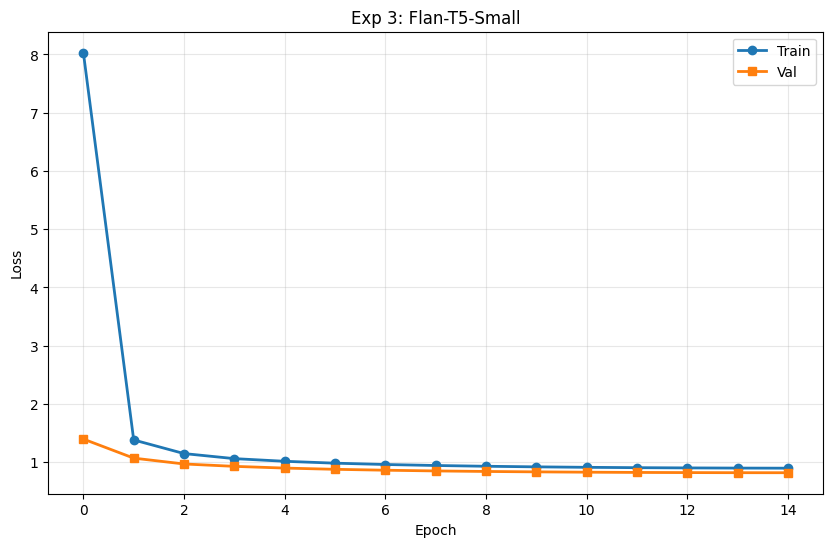

Best Val: 0.8199


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], 'o-', label='Train', lw=2)
plt.plot(history.history['val_loss'], 's-', label='Val', lw=2)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Exp 3: Flan-T5-Small')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()
print(f"Best Val: {min(history.history['val_loss']):.4f}")


## 6. Decoding Strategy Evaluation and Comparison

Text generation quality depends heavily on decoding parameters. We test 5 different strategies:

Strategy Descriptions:
- Baseline: Standard beam search with balanced settings
- Precision-Focused: Favors shorter, more precise answers using higher beam count and lower length penalty
- Balanced: Middle ground between all parameters
- Conservative Beam: Simpler search with fewer beams
- Length-Optimized: Shorter maximum length to encourage concise answers

Each strategy is evaluated on test samples using BLEU and ROUGE metrics. A composite score determines the best overall performer.

In [ ]:
# Define 5 decoding strategies to test
STRATEGIES = {
    'baseline': {
        'name': 'Baseline',
        'params': {
            'max_length': 512,
            'min_length': 10,
            'num_beams': 4,
            'early_stopping': True,
            'no_repeat_ngram_size': 3,
            'length_penalty': 1.0,
            'do_sample': False
        }
    },
    'precision': {
        'name': 'Precision-Focused',
        'params': {
            'max_length': 512,
            'min_length': 20,
            'num_beams': 6,
            'early_stopping': True,
            'no_repeat_ngram_size': 2,
            'length_penalty': 0.6,  # Favor shorter, precise answers
            'repetition_penalty': 1.1,
            'do_sample': False
        }
    },
    'balanced': {
        'name': 'Balanced',
        'params': {
            'max_length': 512,
            'min_length': 15,
            'num_beams': 5,
            'early_stopping': True,
            'no_repeat_ngram_size': 3,
            'length_penalty': 0.8,
            'repetition_penalty': 1.05,
            'do_sample': False
        }
    },
    'conservative': {
        'name': 'Conservative Beam',
        'params': {
            'max_length': 512,
            'min_length': 10,
            'num_beams': 3,
            'early_stopping': True,
            'no_repeat_ngram_size': 3,
            'length_penalty': 1.0,
            'temperature': 1.0,
            'do_sample': False
        }
    },
    'length_optimized': {
        'name': 'Length-Optimized',
        'params': {
            'max_length': 400,  # Shorter max
            'min_length': 15,
            'num_beams': 4,
            'early_stopping': True,
            'no_repeat_ngram_size': 3,
            'length_penalty': 0.7,
            'do_sample': False
        }
    }
}

def generate_answer(question, model, tokenizer, strategy_params):
    """Generate answer with specified decoding strategy."""
    prefix = """You are a medical expert. Provide a clear, accurate, and comprehensive answer to the following medical question.
Focus on being informative and helpful while maintaining medical accuracy.

Question: """
    inputs = tokenizer(
        prefix + question,
        return_tensors='tf',
        max_length=MAX_INPUT_LENGTH,
        truncation=True
    )
    outputs = model.generate(**inputs, **strategy_params)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Load metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

# Number of samples to evaluate
NUM_EVAL = min(30, len(test_df))  # Using 30 samples for quicker evaluation

print(f"\n{'='*80}")
print(f"🧪 TESTING {len(STRATEGIES)} DECODING STRATEGIES")
print(f"{'='*80}")
print(f"Evaluating on {NUM_EVAL} test samples...\n")

# Store results for all strategies
all_results = {}

for strategy_key, strategy_info in STRATEGIES.items():
    print(f"\n{'='*80}")
    print(f"Testing: {strategy_info['name']}")
    print(f"{'='*80}")

    predictions, references = [], []

    # Generate predictions
    for i in range(NUM_EVAL):
        q = test_df.iloc[i]['question']
        true_a = test_df.iloc[i]['answer']

        pred_a = generate_answer(q, model, tokenizer, strategy_info['params'])
        predictions.append(pred_a)
        references.append(true_a)

        if (i + 1) % 10 == 0:  # Progress every 10 samples
            print(f"  {i+1}/{NUM_EVAL}... ({(i+1)/NUM_EVAL*100:.0f}%)")

    # Calculate metrics
    bleu_result = bleu_metric.compute(predictions=predictions, references=[[r] for r in references])
    rouge_result = rouge_metric.compute(predictions=predictions, references=references)

    # Store results
    all_results[strategy_key] = {
        'name': strategy_info['name'],
        'bleu': bleu_result['bleu'],
        'rouge1': rouge_result['rouge1'],
        'rouge2': rouge_result['rouge2'],
        'rougeL': rouge_result['rougeL'],
        'predictions': predictions,
        'references': references,
        'params': strategy_info['params']
    }

    print(f"\n  Results:")
    print(f"    BLEU:    {bleu_result['bleu']:.4f}")
    print(f"    ROUGE-1: {rouge_result['rouge1']:.4f}")
    print(f"    ROUGE-L: {rouge_result['rougeL']:.4f}")

# Calculate composite scores and find best strategy
print(f"\n{'='*80}")
print("📊 STRATEGY COMPARISON")
print(f"{'='*80}")
print(f"{'Strategy':<25} {'BLEU':>10} {'ROUGE-1':>10} {'ROUGE-L':>10} {'Score':>10}")
print(f"{'-'*80}")

for key, results in all_results.items():
    composite = 0.4 * results['bleu'] + 0.4 * results['rougeL'] + 0.2 * results['rouge1']
    results['composite'] = composite
    print(f"{results['name']:<25} {results['bleu']:>10.4f} {results['rouge1']:>10.4f} "
          f"{results['rougeL']:>10.4f} {composite:>10.4f}")

# Find best strategy
best_strategy_key = max(all_results.keys(), key=lambda k: all_results[k]['composite'])
best_strategy = all_results[best_strategy_key]

print(f"\n🏆 BEST STRATEGY: {best_strategy['name']}")
print(f"  BLEU:    {best_strategy['bleu']:.4f}")
print(f"  ROUGE-1: {best_strategy['rouge1']:.4f}")
print(f"  ROUGE-L: {best_strategy['rougeL']:.4f}")
print(f"  Composite Score: {best_strategy['composite']:.4f}")

# Save results
val_loss = min(history.history['val_loss'])
results = {
    'experiment_id': 'exp3_flan_t5_small_prompting',
    'experiment_name': 'Flan-T5-Small with Enhanced Prompting & Strategies',
    'model_name': MODEL_NAME,
    'model_params': int(model.num_parameters()),
    'hyperparameters': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'epochs': EPOCHS,
        'max_input_length': MAX_INPUT_LENGTH,
        'max_target_length': MAX_TARGET_LENGTH
    },
    'strategies_tested': len(STRATEGIES),
    'num_eval_samples': NUM_EVAL,
    'val_loss': float(val_loss),
    'best_strategy': {
        'name': best_strategy['name'],
        'metrics': {
            'bleu': float(best_strategy['bleu']),
            'rouge1': float(best_strategy['rouge1']),
            'rouge2': float(best_strategy['rouge2']),
            'rougeL': float(best_strategy['rougeL']),
            'composite': float(best_strategy['composite'])
        },
        'generation_params': best_strategy['params']
    },
    'all_strategies': {k: {
        'name': v['name'],
        'bleu': float(v['bleu']),
        'rouge1': float(v['rouge1']),
        'rougeL': float(v['rougeL']),
        'composite': float(v['composite'])
    } for k, v in all_results.items()},
    'training_time_seconds': training_time
}

Path('results').mkdir(exist_ok=True)
with open('results/experiment_3_prompting_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n✓ Results saved to results/experiment_3_prompting_results.json")



🧪 TESTING 5 DECODING STRATEGIES
Evaluating on 30 test samples...


Testing: Baseline
  10/30... (33%)
  20/30... (67%)
  30/30... (100%)

  Results:
    BLEU:    0.1095
    ROUGE-1: 0.3638
    ROUGE-L: 0.2809

Testing: Precision-Focused
  10/30... (33%)
  20/30... (67%)
  30/30... (100%)

  Results:
    BLEU:    0.0637
    ROUGE-1: 0.3011
    ROUGE-L: 0.2317

Testing: Balanced
  10/30... (33%)
  20/30... (67%)
  30/30... (100%)

  Results:
    BLEU:    0.1022
    ROUGE-1: 0.3323
    ROUGE-L: 0.2583

Testing: Conservative Beam
  10/30... (33%)
  20/30... (67%)
  30/30... (100%)

  Results:
    BLEU:    0.1333
    ROUGE-1: 0.3599
    ROUGE-L: 0.2861

Testing: Length-Optimized
  10/30... (33%)
  20/30... (67%)
  30/30... (100%)

  Results:
    BLEU:    0.1039
    ROUGE-1: 0.3610
    ROUGE-L: 0.2795

📊 STRATEGY COMPARISON
Strategy                        BLEU    ROUGE-1    ROUGE-L      Score
--------------------------------------------------------------------------------
Baseline          

### Backup Model Weights

Saving a copy of the best model weights to Google Drive for backup and offline access.

In [ ]:
!cp /content/models/experiment_3/best.h5 /content/drive/My\ Drive/files/first

### Hugging Face Authentication

Logging into Hugging Face Hub to enable model upload. You need a Hugging Face account and access token for this step.

In [ ]:
from huggingface_hub import notebook_login

# This will launch a widget/prompt asking you to paste your token from Step 1.
notebook_login()

### Model Deployment to Hugging Face Hub

Uploading the trained model to Hugging Face Hub for easy sharing and deployment. This includes:
- Model weights and architecture
- Tokenizer configuration
- Model card with usage information

The deployed model can be loaded and used by anyone with: `AutoModelForSeq2SeqLM.from_pretrained('reponseashimwe/healthcare-chatbot')`

In [ ]:
# This will create https://huggingface.co/reponseashimwe/healthcare-chatbot
REPO_ID = "reponseashimwe/healthcare-chatbot"

# 2. Push the model weights
print("Pushing model to Hub...")
model.push_to_hub(REPO_ID)

# 3. Push the tokenizer configuration
print("Pushing tokenizer to Hub...")
tokenizer.push_to_hub(REPO_ID)

print(f"Deployment complete! Model is available at: {REPO_ID}")

Pushing model to Hub...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  /tmp/tmpsgk0dcrz/tf_model.h5:   0%|          |  556kB /  440MB            

Pushing tokenizer to Hub...


README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  .../tmpd7325856/spiece.model: 100%|##########|  792kB /  792kB            

Deployment complete! Model is available at: reponseashimwe/healthcare-chatbot
